# EDS Classification for Julia

---
The scripts in this Jupyter notebook show how you can implement three mineral sorting algorithms from the peer-reviewed literature in Julia. The input for each algorithm is a DataFrame of energy dispersive spectrometry (EDS) data. The output is a DataFrame of mineral names corresponding to the likely mineral classification for each row in the input data.

The function code was written and tested in Julia Version 1.8.5 and 1.10.2

### References

- Donarummo et al. (2003).*Geophyiscal Research Letters* **30**(6), 1269. https://doi.org/10.1029/2002GL016641
- Kandler et al. (2011). *Tellus B* **63**(4), 475-496. https://doi.org/10.1111/j.1600-0889.2011.00550.x
- Panta et al. (2023). *Atmos. Chem. Phys.* **23**, 3861-3885. https://doi.org/10.5194/acp-23-3861-2023

---
### Required Packages
There are a few packages that you will need to execute this script successfully. If you do not already have these packages installed, then you will need to add them in the Julia REPL by executing the following:

---
<small>
    
```julia
using Pkg
Pkg.add("Random")
Pkg.add("DataFrames")
Pkg.add("Plots")
```

</small>

---

To load the required packages for the current session:

In [2]:
using Random
using DataFrames
using Plots

## Classification with the Donarummo algorithm

---
### Synthetic data

The Donarummo algorithm requires a DataFrame of EDS net intensity data. There must be a column for each of the following elements: Na, Mg, Al, Si, K, Ca, and Fe. The cell below generates a table of synthetic data (as a DataFrame) that will be used to demonstrate the utility of the sorting algorithm. Note that it does not matter if the columns in the DataFrame are full element names or abbreviations (e.g., "Silicon" vs. "Si"), and capitalization does not matter. **Spelling, however, is paramount!**

---

In [3]:
sz = (1000,1)
Na = rand(1:4000, sz)
Mg = rand(1:1000, sz)
Al = rand(1:12000, sz)
Si = rand(1:30000, sz)
K = rand(1:2000, sz)
Ca = rand(1:4000, sz)
Fe = rand(1:6000, sz)

elements = hcat(Na, Mg, Al, Si, K, Ca, Fe)
element_names = [:Sodium, :Mg, :ALUMinium, :silicon, :K, :Ca, :Fe]
data_table = DataFrame(elements, Symbol.(element_names))
first(data_table,5)

Row,Sodium,Mg,ALUMinium,silicon,K,Ca,Fe
,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,2451,545,1633,11023,63,501,1242
2,3038,470,6861,26305,1182,937,366
3,2097,963,213,11981,13,2070,5537
4,700,60,7620,24323,655,1103,2753
5,1932,775,10728,24438,1916,239,2707


---
### Importing the algorithm

In the following cell block, the Donarummo classification algorithm is imported from the path.

The primary limitation of this algorithm is that it can only identify 16 specific alumninosilcate mineral species. **If the EDS data represents a species that is not recognized by the algorithm then it will be misclassified!** For this reason, it is extremely important to compare the EDS spectra to other possibilities, such as those in Severin, Kenneth P. (2004). "Energy Dispersive Spectrometry of Common Rock-forming Minerals". Kluwer Academic Publishers. 

---

In [4]:
# The function has already been written. It just needs to be imported from the current folder.
include("donarummo_classification.jl");

To view the documentation help for the function, execute the following command in a new cell:

<small>

```julia
?donarummo_classification()
```

</small>

---
### Use

The following cell contains only a single line of code. It takes the <small>`donarummo_classification()`</small> algorithm imported above and applies it to our synthetic DataFrame <small>(`data_table`)</small>. We assign the output of the function to a variable named <small>`minerals`</small>, which is a categorical vector containing the identified mineral name for each row in the input table. 

---

In [5]:
minerals = donarummo_classification(data_table);
first(minerals,5)

Row,Minerals
,String
1,U-C1
2,Olig/Ans
3,Aug
4,Mnt
5,Ilt/Sme


Note that the mineral classifications are given as abbreviations. See the docs `?donarummo_classification` for precise mineral names.

---
### Visualizing the output
The following block of code will count the 

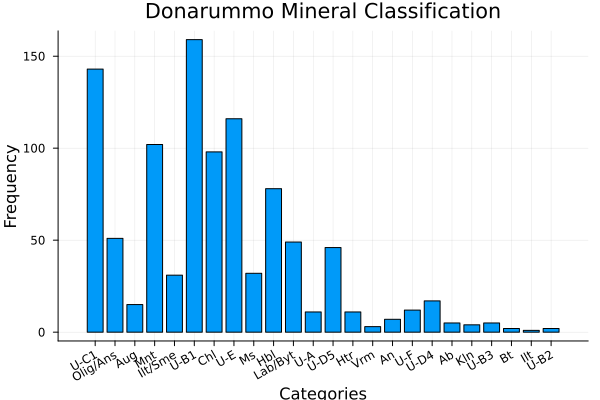

In [6]:
counts = combine(groupby(minerals, :Minerals), nrow => :count)
categories = counts.Minerals
counts = counts.count

plt=Plots.bar(categories, counts,
    xticks=1:length(categories),
    xrotation=30, # <-- For some reason, this optional argument is not in the Plots.jl Documentation...
    tick_direction=:out,
    legend=false,
    xlabel="Categories",
    ylabel="Frequency",
    title="Donarummo Mineral Classification",
    show=true
)
# For some reason, setting the ticks to 1:21 places the ticks 0.5 spaces too far to the right, so we can correct that with the following:
new_xticks = (0.5:length(categories)-0.5, Array(categories)) 
xticks!(new_xticks)

# Classification with the Kandler algorithm
The Kandler algorithm requires EDS atom percent data rather than EDS net intensity data. It does not classify minerals specifically, but rather general mineral classes. Like the Donarummo algorithm and the Panta algorithm, the Kandler algorithm is best used in addition to other classification methods to maximize the certainty of the results.

Use the <small>`include()`</small> function to add the Kandler algorithm to the session.

In [7]:
include("kandler_classification.jl");

In [9]:
# To view the documentation for the Kandler algorithm, un-comment the following line.
# ?kandler_classification()

In [8]:
# Generate synthetic data for demonstrating the Kandler algorithm
sz = (1000,1);
Na = rand(0:20, sz); Mg = rand(0:20, sz); Al = rand(10:70, sz); Si = rand(10:90, sz); 
P  = rand(0:1, sz); S  = rand(0:10, sz); Cl = rand(0:1, sz); K = rand(0:20, sz); Ca = rand(0:20, sz); 
Ti = rand(0:20, sz); Cr = rand(0:0.5, sz); Mn = rand(0:0.5, sz); Fe = rand(0:20, sz)
elements = hcat(Na, Mg, Al, Si, P, S, Cl, K, Ca, Ti, Cr, Mn, Fe)
element_names = [:Sodium, :Mg, :ALUMinium, :silicon, :P, :S, :Cl, :K, :Ca, :Ti, :Cr, :Mn, :Fe]
kandler_data_table = DataFrame(elements, Symbol.(element_names))
# Normalize each row to add to 100
function normalize_to_100!(df::DataFrame)
 data = Matrix(df)
 row_sums = sum(data, dims=2)
 normalization_factors = 100 ./ row_sums
 df .= data .* normalization_factors
 return df
end
kandler_data_table = normalize_to_100!(kandler_data_table)
first(kandler_data_table,1)

Row,Sodium,Mg,ALUMinium,silicon,P,S,Cl,K,Ca,Ti,Cr,Mn,Fe
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,3.44828,9.1954,25.8621,46.5517,0.0,5.17241,0.574713,0.574713,5.74713,1.14943,0.0,0.0,1.72414


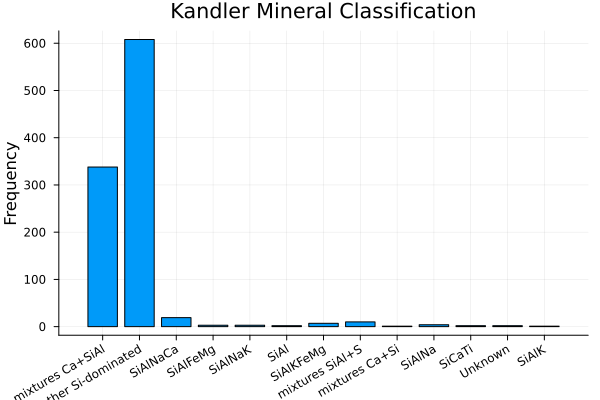

In [9]:
# Apply the algorithm to the synthetic data and visualize the results
kandler_minerals = kandler_classification(kandler_data_table); kandler_counts = combine(groupby(kandler_minerals, :Minerals), nrow => :count)
kandler_cats = kandler_counts.Minerals; kandler_counts = kandler_counts.count
plt=Plots.bar(kandler_cats, kandler_counts,
    xticks=1:length(kandler_cats),
    xrotation=30,
    tick_direction=:out,
    legend=false,
    ylabel="Frequency",
    title="Kandler Mineral Classification",
    show=true
)
new_xticks = (0.5:length(kandler_cats)-0.5, Array(kandler_cats)) 
xticks!(new_xticks)

# Classification with the Panta algorithm
Like the Kandler algorithm, the Panta algorithm also requires EDS atom percent data. The Panta algorithm is also capable of distinguishing 18 unique mineral species and five additional generalized mineral groups. 

Again, use the <small>`include()`</small> function to add the algorithm to the session.

In [10]:
include("panta_classification.jl");

In [13]:
# To view the documentation for the algorithm, un-comment the following line
# ?panta_classification()

In [11]:
# Generate some synthetic data for demonstration purposes
sz = (1000,1);
F = rand(0:0.5, sz); Na = rand(0:20, sz); Mg = rand(0:20, sz); Al = rand(10:70, sz); Si = rand(10:90, sz); 
P  = rand(0:1, sz); S  = rand(0:10, sz); Cl = rand(0:1, sz); K = rand(0:20, sz); Ca = rand(0:20, sz); 
Ti = rand(0:20, sz); Cr = rand(0:0.5, sz); Mn = rand(0:0.5, sz); Fe = rand(0:20, sz)
elements = hcat(F,Na, Mg, Al, Si, P, S, Cl, K, Ca, Ti, Cr, Mn, Fe)
element_names = [:F, :Sodium, :Mg, :ALUMinium, :silicon, :P, :S, :Cl, :K, :Ca, :Ti, :Cr, :Mn, :Fe]
panta_data_table = DataFrame(elements, Symbol.(element_names));
# Normalize rows to add up to 100
panta_data_table = normalize_to_100!(panta_data_table);

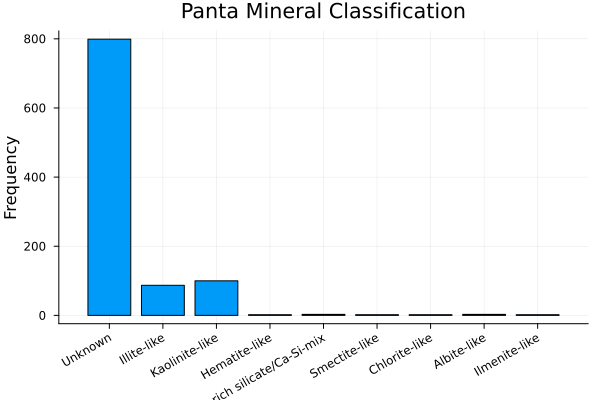

In [12]:
# Apply the algorithm to the synthetic data and visualize the results
panta_minerals = panta_classification(panta_data_table); panta_counts = combine(groupby(panta_minerals, :Minerals), nrow => :count)
panta_cats = panta_counts.Minerals; panta_counts = panta_counts.count
plt=Plots.bar(panta_cats, panta_counts,
    xticks=1:length(panta_cats), xrotation=30, tick_direction=:out,
    legend=false, ylabel="Frequency", title="Panta Mineral Classification", show=true)
new_xticks = (0.5:length(panta_cats)-0.5, Array(panta_cats)); xticks!(new_xticks)